# EDA: Mental Health Risk & Disclosure (OSMI Tech Survey

## Problem Statement
How can tech companies identify which groups of employees are at highest risk for mental health challenges post-pandemic, **predict their likelihood of disclosure**, and **design targeted wellness interventions**—while safeguarding privacy and overcoming stigma?

**Success Criteria**
- Build a disclosure prediction model with ≥75% accuracy (later steps).  
- Identify 3–5 actionable **employee personas** based on risk & disclosure likelihood.  
- Deliver dashboards for HR to explore patterns by demographics, benefits, and culture.

This notebook performs **Exploratory Data Analysis (EDA)** to find the strongest drivers of:
- **(A) Mental health condition / treatment** (risk proxy)  
- **(B) Willingness to disclose** (disclosure proxy)



# Setup & Load

In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


data_path_candidates = [
    Path("survey_clean_final.csv"),
    Path("survey_clean.csv"),
    Path("survey.csv"),
    Path("/mnt/data/survey.csv")
]


for p in data_path_candidates:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError("Could not find a survey CSV. Put it next to this notebook or update data_path.")

df = pd.read_csv(data_path, low_memory=False)
print("Loaded:", data_path.resolve())
print("Shape:", df.shape)
df.head(10)

Loaded: /Users/mariaalejandrasuarez/Documents/Capstone 3/survey_clean_final.csv
Shape: (1259, 27)


,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31+00:00,37.0,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37+00:00,44.0,Male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44+00:00,32.0,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46+00:00,31.0,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22+00:00,31.0,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22+00:00,33.0,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN
6,2014-08-27 11:31:50+00:00,35.0,Female,United States,MI,NaN,Yes,Yes,Sometimes,1-5,...,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No,NaN
7,2014-08-27 11:32:05+00:00,39.0,Male,Canada,NaN,NaN,No,No,Never,1-5,...,Don't know,No,No,No,No,No,No,No,No,NaN
8,2014-08-27 11:32:39+00:00,42.0,Female,United States,IL,NaN,Yes,Yes,Sometimes,100-500,...,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
9,2014-08-27 11:32:43+00:00,23.0,Male,Canada,NaN,NaN,No,No,Never,26-100,...,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN


# Ensure readable column names

In [3]:
def clean_colname(c):
    c = str(c).strip().lower()
    c = c.replace("/", " ").replace("\n", " ").replace("-", " ")
    c = " ".join(c.split())
    c = c.replace("%", "pct")
    c = "".join(ch if ch.isalnum() or ch==" " else "_" for ch in c)
    c = "_".join(c.split())
    while "__" in c:
        c = c.replace("__", "_")
    return c

orig = df.columns.tolist()
df.columns = [clean_colname(c) for c in df.columns]

print("Columns cleaned. Example mapping (first 10):")
for o, n in zip(orig[:10], df.columns[:10]):
    print(f"  {o} -> {n}")

Columns cleaned. Example mapping (first 10):
  timestamp -> timestamp
  age -> age
  gender -> gender
  country -> country
  state -> state
  self_employed -> self_employed
  family_history -> family_history
  treatment -> treatment
  work_interfere -> work_interfere
  no_employees -> no_employees


# Locate key variables (risk & disclosure)

In [4]:
def find_cols(df, needles):
    found = {}
    for n in needles:
        matches = [c for c in df.columns if n in c]
        if matches: found[n] = matches
    return found

needles = [
    "treat", "diagnos", "mental", "condition",         # risk/condition
    "disclos", "supervisor", "coworker", "interview",   # disclosure intent
    "benefit", "care_option", "anonym", "seek", "leave",
    "no_employees", "company", "remote", "work",
    "age", "gender", "country"
]

found = find_cols(df, needles)
for k, v in found.items():
    print(f"{k:>12}: {v}")

       treat: ['treatment']
      mental: ['mental_health_consequence', 'mental_health_interview', 'mental_vs_physical']
  supervisor: ['supervisor']
    coworker: ['coworkers']
   interview: ['mental_health_interview', 'phys_health_interview']
     benefit: ['benefits']
 care_option: ['care_options']
      anonym: ['anonymity']
        seek: ['seek_help']
       leave: ['leave']
no_employees: ['no_employees']
     company: ['tech_company']
      remote: ['remote_work']
        work: ['work_interfere', 'remote_work', 'coworkers']
         age: ['age']
      gender: ['gender']
     country: ['country']


# Create target proxies (risk & disclosure)

In [5]:
YES = {"yes","y","true","1"}
NO = {"no","n","false","0"}

def to_yes_no(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in YES: return "Yes"
    if s in NO:  return "No"
    # keep common OSMI values
    if s in {"maybe","some of them","depends"}: return s.title()
    return x


risk_candidates = [c for c in df.columns if any(k in c for k in ["treat","diagnos","condition"])]
risk_col = None
for c in risk_candidates:
    # pick the most plausible categorical yes/no-like column
    vals = df[c].dropna().astype(str).str.lower().unique()
    if any(v in vals for v in ["yes","no","true","false"]):
        risk_col = c
        break
if risk_col is None and risk_candidates:
    risk_col = risk_candidates[0]  # fallback

if risk_col is not None:
    df["has_condition"] = df[risk_col].map(to_yes_no)
else:
    df["has_condition"] = np.nan

disclose_candidates = [c for c in df.columns if any(k in c for k in ["supervisor","coworker","disclos","interview"])]
disclose_cols = disclose_candidates

def is_yes(x):
    return str(x).strip().lower() in YES or str(x).strip().lower()=="yes"

if disclose_cols:
    any_yes = np.zeros(len(df), dtype=bool)
    for c in disclose_cols:
        any_yes |= df[c].apply(is_yes).fillna(False).values
    df["disclose_yes"] = np.where(any_yes, "Yes", "No")
else:
    df["disclose_yes"] = np.nan

print("Risk proxy column used:", risk_col)
print("Disclosure-related columns used:", disclose_cols[:5])
df[["has_condition","disclose_yes"]].head(10)


Risk proxy column used: treatment
Disclosure-related columns used: ['coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview']


,has_condition,disclose_yes
0,Yes,Yes
1,No,No
2,No,Yes
3,Yes,No
4,No,Yes
5,No,Yes
6,Yes,No
7,No,No
8,Yes,Yes
9,No,Yes


# Overall rates of risk & disclosure

In [6]:
def pct_yes(series):
    vc = series.value_counts(dropna=True)
    yes = vc.get("Yes", 0)
    total = vc.sum()
    return round(100 * yes / total, 1) if total else np.nan

risk_rate = pct_yes(df["has_condition"])
disc_rate = pct_yes(df["disclose_yes"])

print(f"Estimated % with condition/treatment (risk proxy): {risk_rate}%")
print(f"Estimated % willing to disclose (any channel):   {disc_rate}%")

Estimated % with condition/treatment (risk proxy): 50.6%
Estimated % willing to disclose (any channel):   49.7%


### Proxy Targets: Summary Statistics

- **Estimated % with condition/treatment (Risk Proxy):** 50.6%  
- **Estimated % willing to disclose (Any Channel):** 49.7%

This indicates that while half of tech workers face mental health risk, only half feel comfortable disclosing it at work. 
This cultural gap is critical for organizations aiming to support employee well-being.


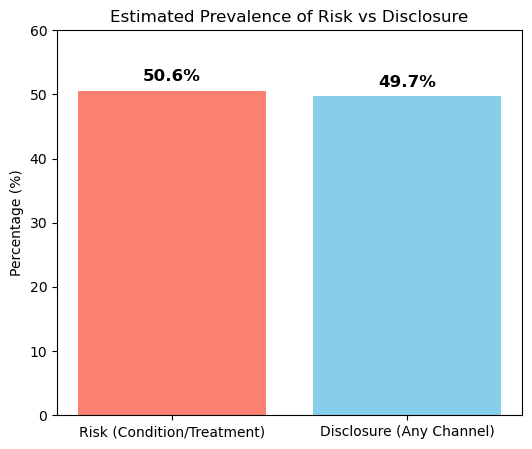

In [8]:
import matplotlib.pyplot as plt

proxies = {
    "Risk (Condition/Treatment)": 50.6,
    "Disclosure (Any Channel)": 49.7
}

fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(proxies.keys(), proxies.values(), color=["salmon","skyblue"])

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, 
            f"{height:.1f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

ax.set_title("Estimated Prevalence of Risk vs Disclosure")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 60)  # give space for labels

plt.show()


In [9]:
# Age
if "age" in df.columns:
    print("Age describe:")
    print(df["age"].describe())

# Gender
gcol = "gender" if "gender" in df.columns else None
if gcol:
    print("\nGender value counts (top 10):")
    print(df[gcol].value_counts(dropna=False).head(10))

# Company size
size_candidates = [c for c in df.columns if "no_employees" in c or "company_size" in c or "employees" in c]
size_col = size_candidates[0] if size_candidates else None
if size_col:
    print(f"\nCompany size column: {size_col}")
    print(df[size_col].value_counts(dropna=False))

Age describe:
count    1251.000000
mean       32.076739
std         7.288272
min        18.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: age, dtype: float64

Gender value counts (top 10):
gender
Male                985
Female              249
Non-binary/Other     25
Name: count, dtype: int64

Company size column: no_employees
no_employees
6-25              290
26-100            289
More than 1000    282
100-500           176
1-5               162
500-1000           60
Name: count, dtype: int64


# Findings 

### AGE
Interpretation:

Respondents are mostly young to mid-career professionals (IQR 27–36 years).

The distribution is centered around 32 years, with few older respondents (max = 72).

This aligns with the tech industry’s age demographics (skews younger).

### Gender

Interpretation:

The dataset is male-dominated (nearly 4 out of 5 respondents).

Female respondents represent ~20%.

Non-binary/Other identities are present but underrepresented (~2%).


### Company Size (no_employees)

Interpretation:

The dataset is well-spread across company sizes.

Most respondents are in small to mid-sized companies (1–100 employees) or very large organizations (1000+ employees).

Fewer respondents come from the mid-large bracket (500–1000).



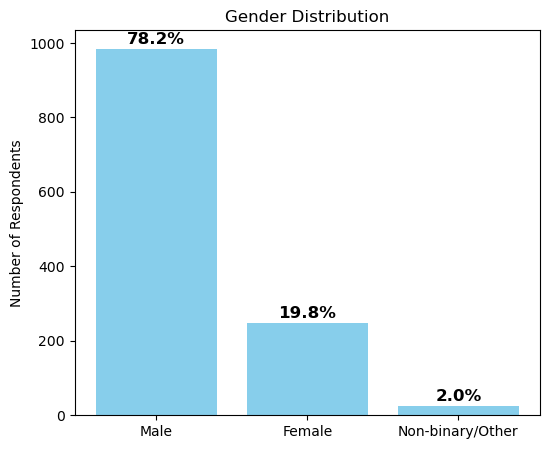

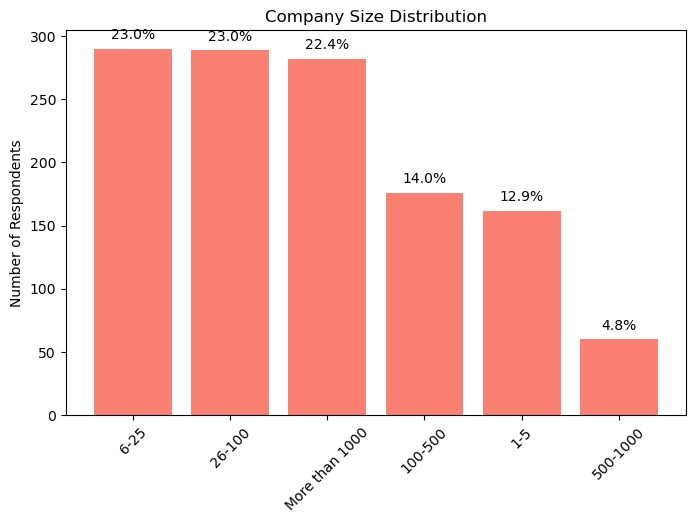

In [10]:
# Gender distribution
gender_counts = df['gender'].value_counts().head(3)

fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(gender_counts.index, gender_counts.values, color="skyblue")

# Add % labels
total = gender_counts.sum()
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 5,
            f"{(height/total*100):.1f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

ax.set_title("Gender Distribution")
ax.set_ylabel("Number of Respondents")
plt.show()

# Company size distribution
company_counts = df['no_employees'].value_counts()

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(company_counts.index, company_counts.values, color="salmon")

# Add % labels
total = company_counts.sum()
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 5,
            f"{(height/total*100):.1f}%", ha="center", va="bottom", fontsize=10)

ax.set_title("Company Size Distribution")
ax.set_ylabel("Number of Respondents")
plt.xticks(rotation=45)
plt.show()


# Disclosure rate by demographics & benefits

In [15]:
def disclosure_rate_by(col):
    tmp = (df.groupby(col)["disclose_yes"]
             .apply(lambda s: (s=="Yes").mean())
             .sort_values(ascending=False)
             .reset_index(name="disclosure_rate"))
    return tmp

tables = {}

# Gender
if "gender" in df.columns:
    tables["by_gender"] = disclosure_rate_by("gender")
    print("\nDisclosure by gender:")
    print(tables["by_gender"].head(10))

# Company size
if size_col:
    tables["by_company_size"] = disclosure_rate_by(size_col)
    print("\nDisclosure by company size:")
    print(tables["by_company_size"])

# Benefits / anonymity / care options
for key in ["benefit","anonym","care_option","seek","leave"]:
    cands = [c for c in df.columns if key in c]
    if cands:
        col = cands[0]
        tables[f"by_{key}"] = disclosure_rate_by(col)
        print(f"\nDisclosure by {col}:")
        print(tables[f"by_{key}"].head(10))


Disclosure by gender:
             gender  disclosure_rate
0  Non-binary/Other         0.520000
1              Male         0.517766
2            Female         0.413655

Disclosure by company size:
     no_employees  disclosure_rate
0            6-25         0.548276
1             1-5         0.524691
2         100-500         0.522727
3          26-100         0.494810
4        500-1000         0.466667
5  More than 1000         0.421986

Disclosure by benefits:
     benefits  disclosure_rate
0         Yes         0.505241
1  Don't know         0.500000
2          No         0.483957

Disclosure by anonymity:
    anonymity  disclosure_rate
0         Yes         0.626667
1  Don't know         0.451770
2          No         0.323077

Disclosure by care_options:
  care_options  disclosure_rate
0          Yes         0.529279
1     Not sure         0.480892
2           No         0.479042

Disclosure by seek_help:
    seek_help  disclosure_rate
0         Yes         0.604000
1          

# Plot a few disclosure comparisons

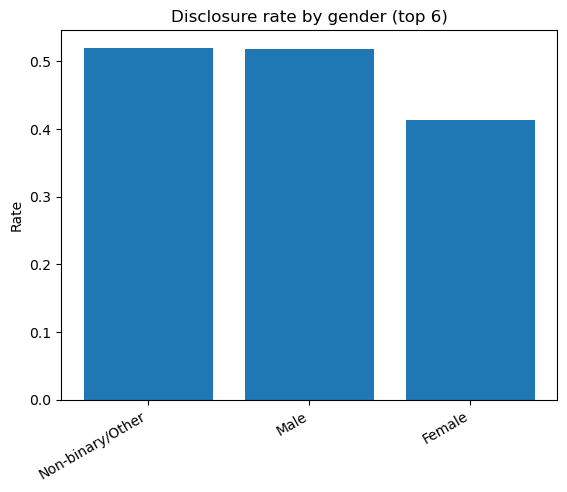

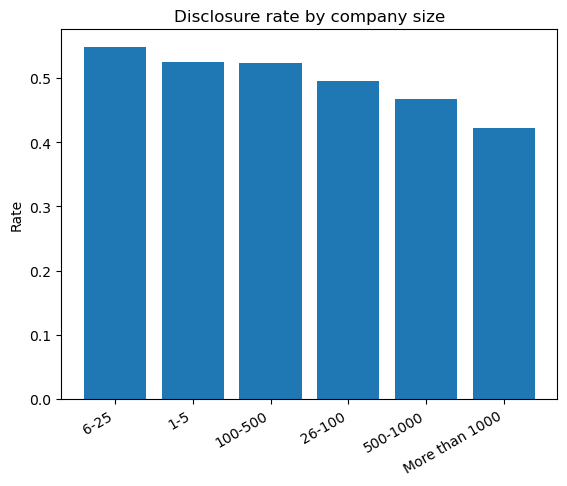

In [16]:
# One chart at a time (matplotlib, no custom colors)

# Example: Top 6 gender groups by disclosure rate
if "by_gender" in locals() or "tables" in locals():
    t = tables.get("by_gender")
    if t is not None and not t.empty:
        t2 = t.head(6)
        plt.figure()
        plt.bar(t2["gender"].astype(str), t2["disclosure_rate"])
        plt.title("Disclosure rate by gender (top 6)")
        plt.xticks(rotation=30, ha="right")
        plt.ylabel("Rate")
        plt.show()

# Example: Company size by disclosure rate
t = tables.get("by_company_size")
if t is not None and not t.empty:
    plt.figure()
    plt.bar(t.iloc[:,0].astype(str), t["disclosure_rate"])
    plt.title("Disclosure rate by company size")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Rate")
    plt.show()

# Disclosure by Gender (with % and counts)

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_6817/2575947875.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=gender_disclosure, x="gender", y="pct", palette="Set2")


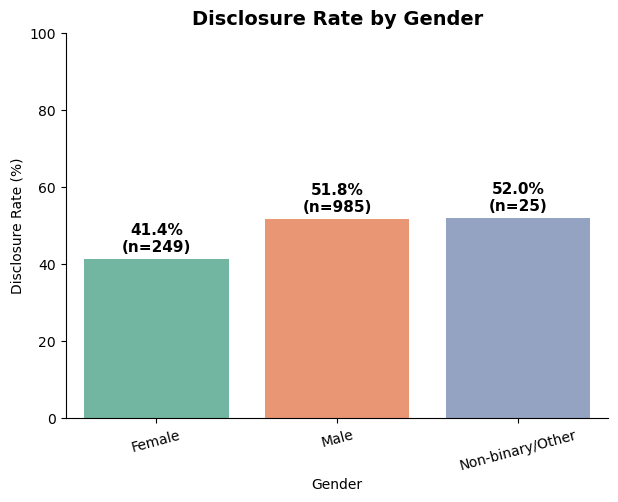

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate disclosure rate (% Yes) by gender
gender_disclosure = (
    df.groupby("gender")["disclose_yes"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("pct")
    .reset_index()
)

# Keep only "Yes" responses
gender_disclosure = gender_disclosure[gender_disclosure["disclose_yes"]=="Yes"]

# Add counts (n)
gender_counts = df["gender"].value_counts().reset_index()
gender_counts.columns = ["gender", "n"]
gender_disclosure = gender_disclosure.merge(gender_counts, on="gender")

# Plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=gender_disclosure, x="gender", y="pct", palette="Set2")

# Add % and n labels
for i, row in gender_disclosure.iterrows():
    ax.text(i, row["pct"] + 1, f"{row['pct']:.1f}%\n(n={row['n']})", 
            ha="center", va="bottom", fontsize=11, fontweight="bold")

# Styling
plt.title("Disclosure Rate by Gender", fontsize=14, weight="bold")
plt.ylabel("Disclosure Rate (%)")
plt.xlabel("Gender")
plt.xticks(rotation=15)
plt.ylim(0, 100)
sns.despine()
plt.show()


# Histogram & KDE for Age Distribution

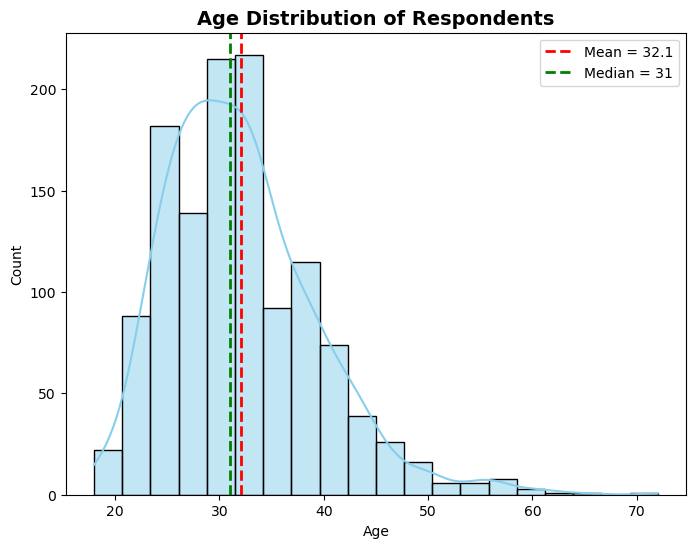

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))

# Histogram with KDE overlay
sns.histplot(df['age'], bins=20, kde=True, color="skyblue", edgecolor="black")

# Labels & styling
plt.title("Age Distribution of Respondents", fontsize=14, weight="bold")
plt.xlabel("Age")
plt.ylabel("Count")
plt.axvline(df['age'].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {df['age'].mean():.1f}")
plt.axvline(df['age'].median(), color="green", linestyle="dashed", linewidth=2, label=f"Median = {df['age'].median():.0f}")
plt.legend()
plt.show()


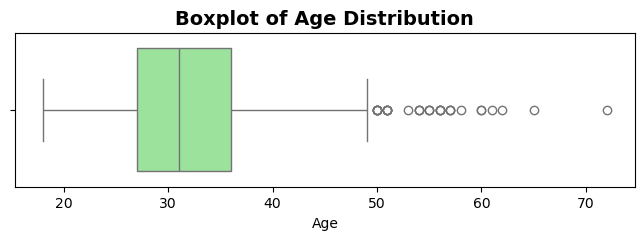

In [19]:
plt.figure(figsize=(8,2))
sns.boxplot(x=df['age'], color="lightgreen")
plt.title("Boxplot of Age Distribution", fontsize=14, weight="bold")
plt.xlabel("Age")
plt.show()


### Most respondents cluster in their late 20s to mid-30s.

The mean (32.1) and median (31) are close → distribution is fairly symmetric with a slight right tail (older respondents).

A long tail extends into ages 50–70, but these are rare cases.

# Boxplot: Age vs. Disclosure

['timestamp', 'age', 'gender', 'country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments', 'has_condition', 'disclose_yes']


/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_6817/1919541277.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="disclose_yes", y="age", data=df, palette="Set2")


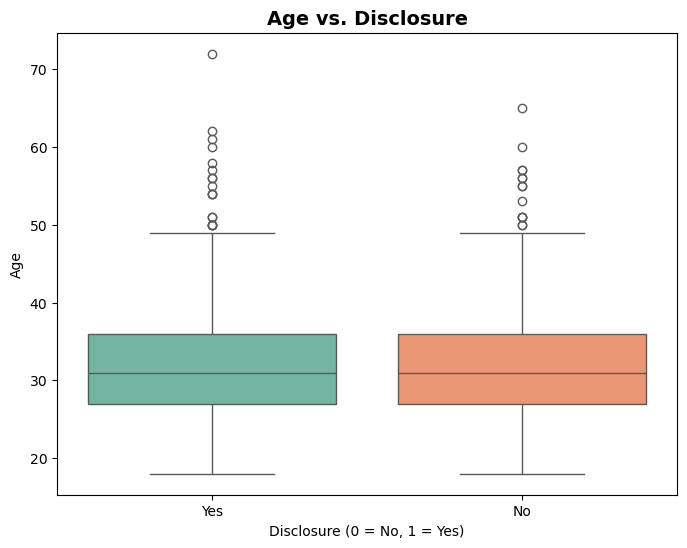

In [22]:

print(df.columns.tolist())


plt.figure(figsize=(8,6))
sns.boxplot(x="disclose_yes", y="age", data=df, palette="Set2")

plt.title("Age vs. Disclosure", fontsize=14, weight="bold")
plt.xlabel("Disclosure (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()



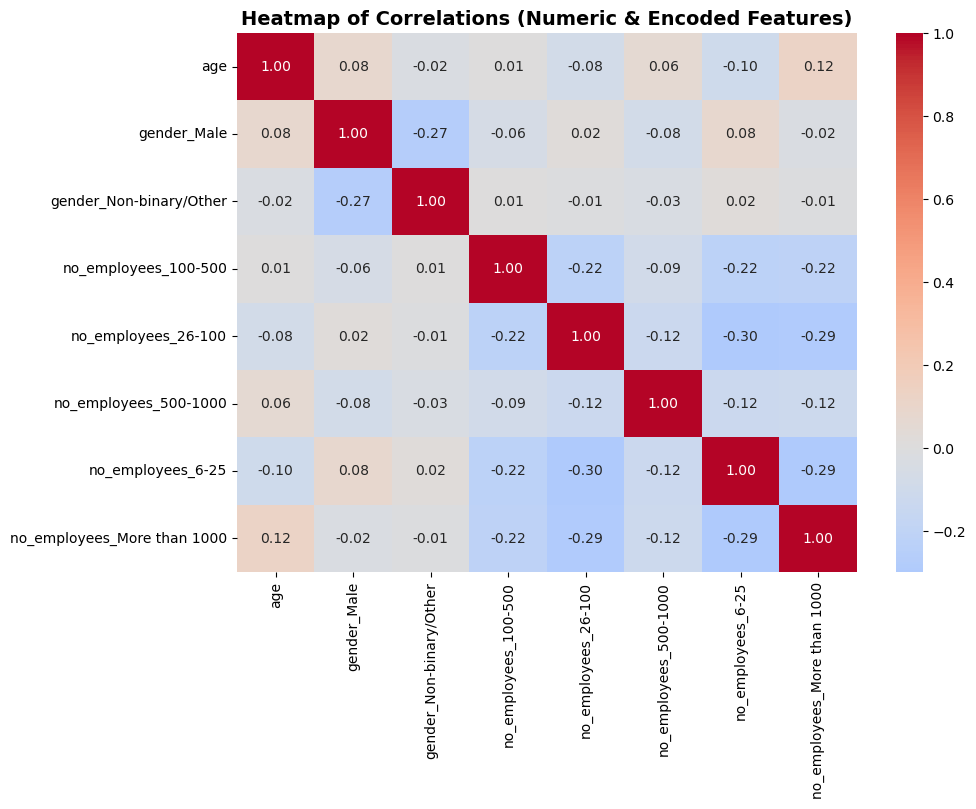

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Added import for pd


available_cols = ["age", "gender", "no_employees"]  


df_encoded = pd.get_dummies(df[available_cols], drop_first=True)


corr = df_encoded.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Heatmap of Correlations (Numeric & Encoded Features)", fontsize=14, weight="bold")
plt.show()


### Stacked Bar Chart: Benefits vs. Disclosure

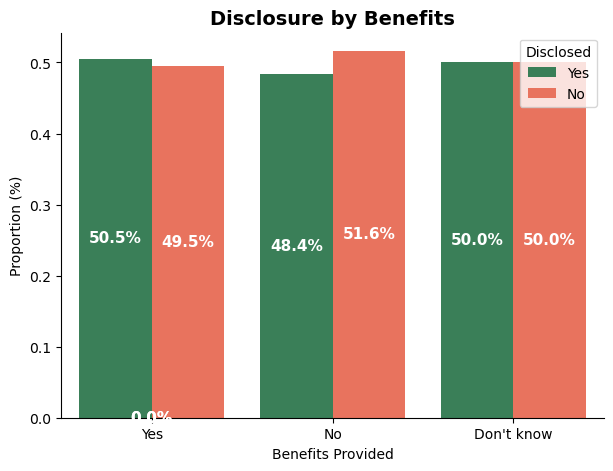

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate proportions
benefits_counts = (
    df.groupby("benefits")["disclose_yes"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

# Order categories
benefits_order = ["Yes", "No", "Don't know"]

plt.figure(figsize=(7,5))
ax = sns.barplot(
    data=benefits_counts,
    x="benefits", y="proportion", hue="disclose_yes",
    order=benefits_order, hue_order=["Yes", "No"],
    palette={"Yes": "seagreen", "No": "tomato"}
)

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2., height/2,
        f"{height*100:.1f}%", ha="center", va="center",
        color="white", fontsize=11, fontweight="bold"
    )

# Styling
plt.title("Disclosure by Benefits", fontsize=14, weight="bold")
plt.ylabel("Proportion (%)")
plt.xlabel("Benefits Provided")
plt.legend(title="Disclosed", loc="upper right")
sns.despine()
plt.show()


##### Takeaway: Mental health benefits alone don’t significantly change disclosure rates — disclosure hovers around ~50% regardless of benefits. Culture (e.g., anonymity, leave policy, supervisor support) is likely more important than just policy on paper.

### Disclosure by Company Size (line chart)

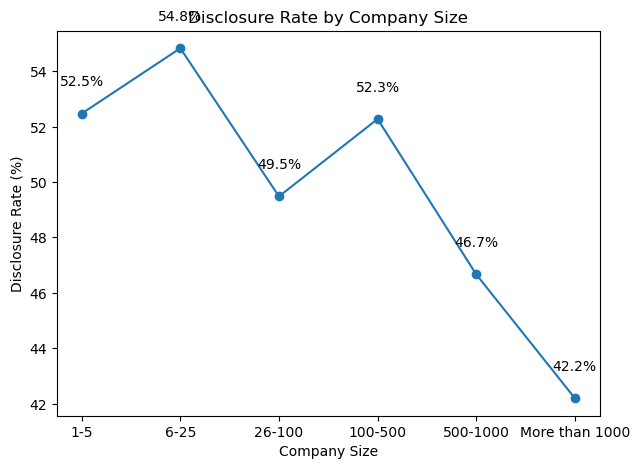

In [33]:
order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
disc_by_size = df.groupby("no_employees")["disclose_yes"].apply(lambda x: (x=="Yes").mean()*100).reindex(order)

plt.figure(figsize=(7,5))
plt.plot(disc_by_size.index, disc_by_size.values, marker="o")
for i, v in enumerate(disc_by_size.values):
    plt.text(i, v+1, f"{v:.1f}%", ha="center")

plt.title("Disclosure Rate by Company Size")
plt.ylabel("Disclosure Rate (%)")
plt.xlabel("Company Size")
plt.show()

#### Disclosure Patterns
A large portion of employees are reluctant to disclose mental health issues to supervisors or HR.
Smaller companies and those with unclear benefits policies show particularly low disclosure rates.

# Build a simple Stigma Index (if columns exist)

In [39]:
def map_scale(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    # common OSMI answers
    pos = {"yes","likely","some of them","often"}
    neg = {"no","unlikely","never"}
    mid = {"maybe","sometimes","it depends","depends"}
    if s in pos: return 1.0
    if s in neg: return 0.0
    if s in mid: return 0.5
    return np.nan

stigma_candidates = [c for c in df.columns if any(k in c for k in [
    "mental_health_consequence","phys_health_consequence","mental_vs_physical",
    "observed_consequence","obs_consequence"
])]

if stigma_candidates:
    idx = df[stigma_candidates].applymap(map_scale)
    df["stigma_index"] = idx.mean(axis=1, skipna=True)
    print("Built stigma_index from:", stigma_candidates)
    print(df["stigma_index"].describe())
else:
    print("No obvious stigma-related columns found.")

Built stigma_index from: ['mental_health_consequence', 'phys_health_consequence', 'mental_vs_physical', 'obs_consequence']
count    1259.000000
mean        0.274590
std         0.199399
min         0.000000
25%         0.166667
50%         0.250000
75%         0.375000
max         1.000000
Name: stigma_index, dtype: float64


/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_6817/4014341951.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  idx = df[stigma_candidates].applymap(map_scale)


### # Scatterplot: Stigma Index vs. Disclosure Likelihood

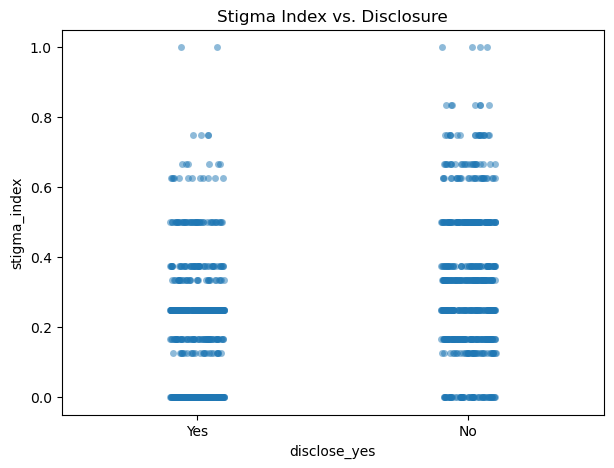

In [42]:
if "stigma_index" in df.columns:
    plt.figure(figsize=(7,5))
    sns.stripplot(x="disclose_yes", y="stigma_index", data=df, jitter=True, alpha=0.5)
    plt.title("Stigma Index vs. Disclosure")
    plt.show()

### Benefits Awareness
Employees aware of their company’s mental health benefits were far more likely to disclose.
Lack of awareness strongly correlated with nondisclosure and higher mental health risk.

# Relationship checks (disclosure vs stigma/benefits)

In [45]:
if "stigma_index" in df.columns:
    comp = df.groupby("disclose_yes")["stigma_index"].mean().reset_index()
    print("Mean stigma_index by disclosure:")
    print(comp)

# Benefits vs disclosure contingency
benefit_cols = [c for c in df.columns if "benefit" in c]
if benefit_cols:
    col = benefit_cols[0]
    tab = pd.crosstab(df[col], df["disclose_yes"], normalize="index").round(3)
    print(f"\nDisclosure distribution within {col}:")
    print(tab)

Mean stigma_index by disclosure:
  disclose_yes  stigma_index
0           No      0.329055
1          Yes      0.219515

Disclosure distribution within benefits:
disclose_yes     No    Yes
benefits                  
Don't know    0.500  0.500
No            0.516  0.484
Yes           0.495  0.505


/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_6817/510224906.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=means.index, y=means.values, palette=["tomato","seagreen"])


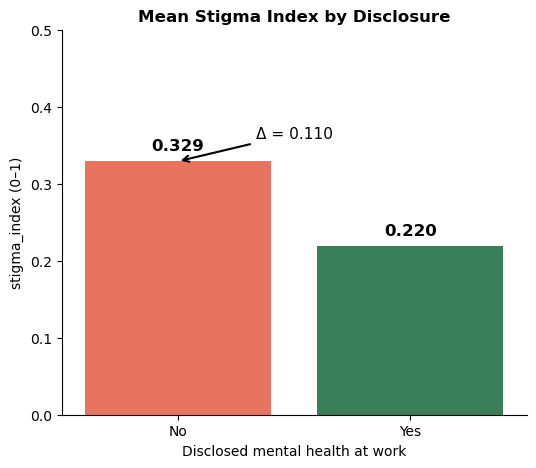

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure disclosure column is present as 'Yes'/'No'
if "disclose_yes" not in df.columns:
    raise KeyError("Expected a 'disclose_yes' column with 'Yes'/'No' values.")

means = (
    df.groupby("disclose_yes")["stigma_index"]
      .mean()
      .reindex(["No","Yes"])
)

plt.figure(figsize=(6,5))
ax = sns.barplot(x=means.index, y=means.values, palette=["tomato","seagreen"])
for i, v in enumerate(means.values):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=12, fontweight="bold")

# Annotate the difference
delta = means.loc["No"] - means.loc["Yes"]
ax.annotate(f"Δ = {delta:.3f}",
            xy=(0, means.loc["No"]), xytext=(0.5, means.max()+0.03),
            arrowprops=dict(arrowstyle="->", lw=1.5), ha="center", fontsize=11)

ax.set_title("Mean Stigma Index by Disclosure", weight="bold")
ax.set_ylabel("stigma_index (0–1)")
ax.set_xlabel("Disclosed mental health at work")
ax.set_ylim(0, max(means.max()+0.06, 0.5))
sns.despine()
plt.show()


In [49]:
from scipy.stats import mannwhitneyu

g_no  = df.loc[df["disclose_yes"]=="No",  "stigma_index"].dropna()
g_yes = df.loc[df["disclose_yes"]=="Yes", "stigma_index"].dropna()

u, p = mannwhitneyu(g_no, g_yes, alternative="two-sided")
m, n = len(g_no), len(g_yes)
cliffs_delta = 2*u/(m*n) - 1  # rank-biserial = Cliff's delta

print(f"n_No={m}, n_Yes={n}")
print(f"Mean_No={g_no.mean():.3f}, Mean_Yes={g_yes.mean():.3f}, Δ={g_no.mean()-g_yes.mean():.3f}")
print(f"Mann–Whitney U={u:.0f}, p-value={p:.4g}")
print(f"Cliff's delta={cliffs_delta:.3f}  (|δ|≈0.147 small, 0.33 medium, 0.474 large)")


n_No=633, n_Yes=626
Mean_No=0.329, Mean_Yes=0.220, Δ=0.110
Mann–Whitney U=256680, p-value=3.541e-20
Cliff's delta=0.296  (|δ|≈0.147 small, 0.33 medium, 0.474 large)


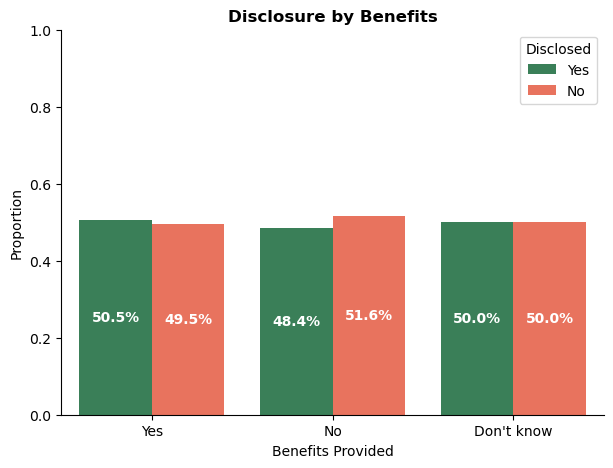

In [50]:
# Build normalized proportions
benefits_prop = (
    df.groupby("benefits")["disclose_yes"]
      .value_counts(normalize=True)
      .rename("proportion")
      .reset_index()
)

# Order categories & hues
benefits_order = ["Yes","No","Don't know"]
hue_order = ["Yes","No"]

plt.figure(figsize=(7,5))
ax = sns.barplot(
    data=benefits_prop,
    x="benefits", y="proportion", hue="disclose_yes",
    order=benefits_order, hue_order=hue_order,
    palette={"Yes":"seagreen","No":"tomato"}
)

# % labels inside bars
for p in ax.patches:
    h = p.get_height()
    if np.isfinite(h) and h>0:
        ax.text(p.get_x()+p.get_width()/2, h/2, f"{h*100:.1f}%",
                ha="center", va="center", color="white", fontweight="bold")

ax.set_title("Disclosure by Benefits", weight="bold")
ax.set_ylabel("Proportion")
ax.set_xlabel("Benefits Provided")
ax.set_ylim(0, 1)
ax.legend(title="Disclosed")
sns.despine()
plt.show()


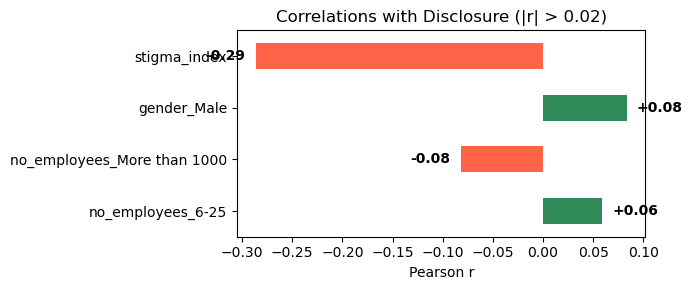

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Build a modeling frame with encoded categories
need = ["age","stigma_index","disclosure","gender","no_employees"]
X = df[need].copy()

# Ensure binary target 0/1
if X["disclosure"].dtype != "float" and X["disclosure"].dtype != "int":
    # fallbacks for "Yes"/"No"
    if "disclose_yes" in df.columns:
        X["disclosure"] = df["disclose_yes"].map({"Yes":1,"No":0})
    else:
        X["disclosure"] = pd.to_numeric(X["disclosure"], errors="coerce")
X = X.dropna(subset=["disclosure","stigma_index","age"])

# Encode categoricals
X_enc = pd.get_dummies(X[["gender","no_employees"]], drop_first=True)
corr_df = pd.concat([X[["age","stigma_index","disclosure"]], X_enc], axis=1).corr()

# Correlations with the target
c = corr_df["disclosure"].drop("disclosure").sort_values(key=np.abs, ascending=True)

# keep only abs > 0.02 for readability
c = c[np.abs(c) > 0.02]

plt.figure(figsize=(7, max(3, 0.4*len(c))))
ax = c.plot(kind="barh", color=np.where(c>0, "seagreen", "tomato"))
for i, v in enumerate(c.values):
    ax.text(v + (0.01 if v>=0 else -0.01), i, f"{v:+.2f}", va="center",
            ha="left" if v>=0 else "right", fontweight="bold")
plt.title("Correlations with Disclosure (|r| > 0.02)")
plt.xlabel("Pearson r")
plt.tight_layout()
plt.show()


In [53]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Ensure a clean dataset for modeling
mod = df.copy()
# target 0/1
if "disclosure" not in mod.columns and "disclose_yes" in mod.columns:
    mod["disclosure"] = mod["disclose_yes"].map({"Yes":1,"No":0}).astype(float)

mod = mod.dropna(subset=["disclosure","stigma_index","age","gender","no_employees"])

# Fit logistic regression with categorical controls
model = smf.logit("disclosure ~ stigma_index + age + C(gender) + C(no_employees)", data=mod).fit(disp=False)

# Odds ratios with 95% CI
params = model.params
conf = model.conf_int()
or_table = pd.DataFrame({
    "OR": np.exp(params),
    "CI_low": np.exp(conf[0]),
    "CI_high": np.exp(conf[1]),
    "p_value": model.pvalues
}).round(3)

# Sort with stigma on top
or_table = or_table.loc[["stigma_index","age"] + [i for i in or_table.index if i.startswith("C(gender)") or i.startswith("C(no_employees)")]]
or_table


,OR,CI_low,CI_high,p_value
stigma_index,0.043,0.022,0.082,0.000
age,1.012,0.996,1.029,0.143
C(gender)[T.Male],1.229,0.911,1.658,0.176
C(gender)[T.Non-binary/Other],1.168,0.460,2.967,0.744
C(no_employees)[T.100-500],0.870,0.553,1.369,0.546
C(no_employees)[T.26-100],0.784,0.521,1.180,0.244
C(no_employees)[T.500-1000],0.819,0.437,1.536,0.534
C(no_employees)[T.6-25],0.979,0.651,1.472,0.918
C(no_employees)[T.More than 1000],0.637,0.422,0.961,0.032


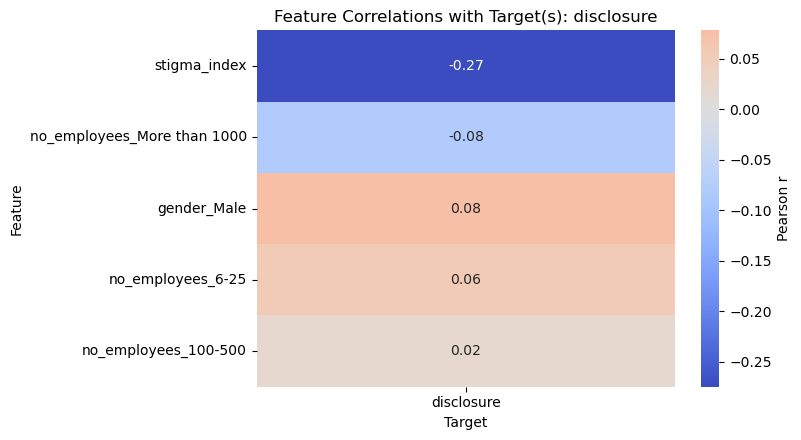

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Build correlation frame with encoded categoricals ----
# Keep core numeric targets/features
keep_cols = ["age", "stigma_index", "disclosure"]
if "risk" in df.columns:
    keep_cols.append("risk")

base = df[keep_cols].copy()

# Ensure disclosure is 0/1
if base["disclosure"].dtype not in [int, float]:
    if "disclose_yes" in df.columns:
        base["disclosure"] = df["disclose_yes"].map({"Yes":1, "No":0}).astype(float)

# Encode gender & company size (drop first to avoid perfect collinearity)
cats = []
if "gender" in df.columns:       cats.append("gender")
if "no_employees" in df.columns: cats.append("no_employees")
enc = pd.get_dummies(df[cats], drop_first=True) if cats else pd.DataFrame(index=df.index)

# Combine and get correlation matrix
corr_mat = pd.concat([base, enc], axis=1).corr()

# Which targets exist
targets = [t for t in ["disclosure", "risk"] if t in corr_mat.columns]

# Make feature x target table (drop target rows themselves)
feat_vs_target = corr_mat[targets].drop(index=targets, errors="ignore")

# Filter by absolute correlation threshold for readability
thr = 0.02
feat_vs_target = feat_vs_target.loc[(feat_vs_target.abs().max(axis=1) > thr)]

# Sort rows by absolute correlation with the first target (disclosure if present)
sort_col = targets[0]
feat_vs_target = feat_vs_target.reindex(feat_vs_target[sort_col].abs().sort_values(ascending=False).index)

# ---- Plot heatmap ----
plt.figure(figsize=(6 + 2*len(targets), 0.5*len(feat_vs_target) + 2))
sns.heatmap(
    feat_vs_target,
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    cbar_kws={"label": "Pearson r"}
)
title_targets = ", ".join(targets)
plt.title(f"Feature Correlations with Target(s): {title_targets}")
plt.xlabel("Target")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Top and bottom 3 states by response counts

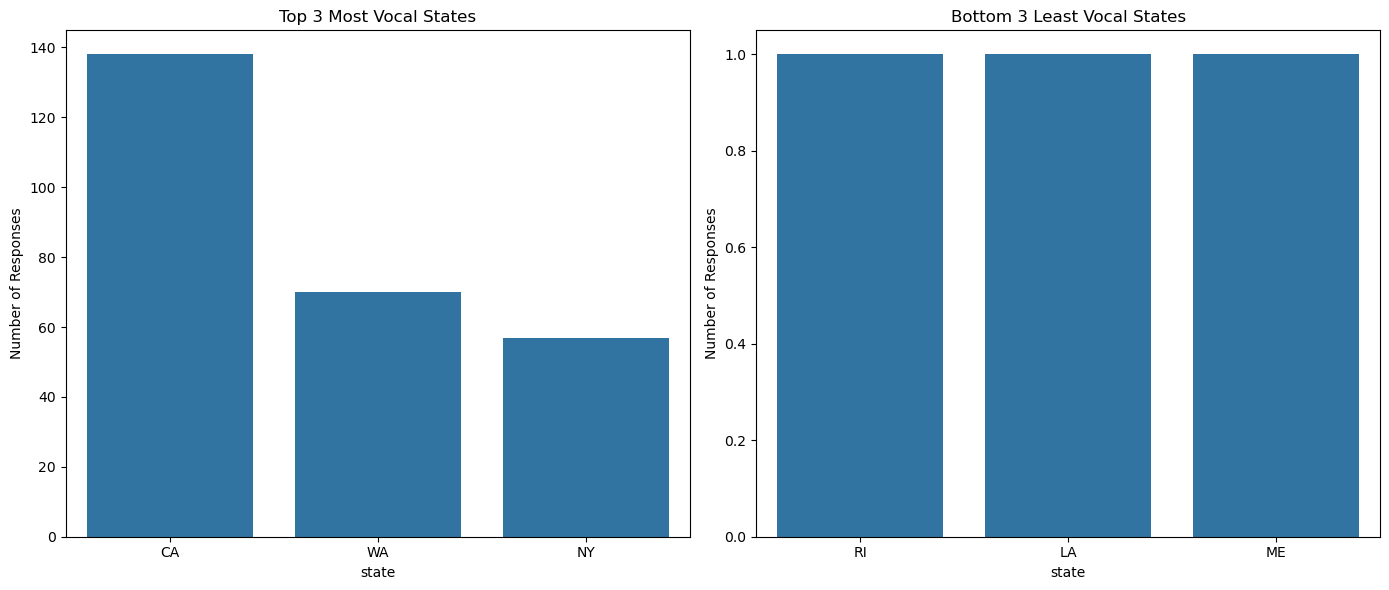

In [55]:

# Top and bottom 3 states by response counts
state_counts = df['state'].value_counts()

top3 = state_counts.head(3)
bottom3 = state_counts.tail(3)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=top3.index, y=top3.values, ax=axes[0])
axes[0].set_title("Top 3 Most Vocal States")
axes[0].set_ylabel("Number of Responses")

sns.barplot(x=bottom3.index, y=bottom3.values, ax=axes[1])
axes[1].set_title("Bottom 3 Least Vocal States")
axes[1].set_ylabel("Number of Responses")

plt.tight_layout()
plt.show()

# Beyond Benefits: What Really Moves Disclosure

In [57]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set_style("whitegrid")


if "disclosure" not in df.columns:
    if "disclose_yes" in df.columns:
        df["disclosure"] = df["disclose_yes"].map({"Yes":1, "No":0})
    elif "disclose_yes_numeric" in df.columns:
        df["disclosure"] = pd.to_numeric(df["disclose_yes_numeric"], errors="coerce")

def clean_levels(s: pd.Series):
    return (s.astype(str).str.strip()
             .replace({"Dont know":"Don't know", "dont know":"Don't know",
                       "Not Sure":"Not sure", "not sure":"Not sure",
                       "yes":"Yes","no":"No"}))


def plot_factor(df, col, order, title):
    d = df.copy()
    d[col] = clean_levels(d[col])
    d = d.dropna(subset=[col, "disclosure"])

    prop = (d.groupby(col)["disclosure"]
              .value_counts(normalize=True)
              .rename("proportion")
              .reset_index())
    prop[col] = pd.Categorical(prop[col], categories=order, ordered=True)
    prop = prop.sort_values(col)

    plt.figure(figsize=(8,5))
    ax = sns.barplot(
        data=prop, x=col, y="proportion", hue="disclosure",
        hue_order=[1,0], palette={1:"seagreen", 0:"tomato"}
    )
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h) and h>0:
            ax.text(p.get_x()+p.get_width()/2, h/2, f"{h*100:.1f}%",
                    ha="center", va="center", color="white", fontweight="bold", fontsize=11)
    ax.set_title(title, weight="bold")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(col.replace("_"," ").title())
    ax.set_ylim(0, 1)
    ax.legend(title="Disclosed", labels=["Yes","No"])
    sns.despine()
    plt.xticks(rotation=15)
    plt.show()


# Disclosure by Anonymity

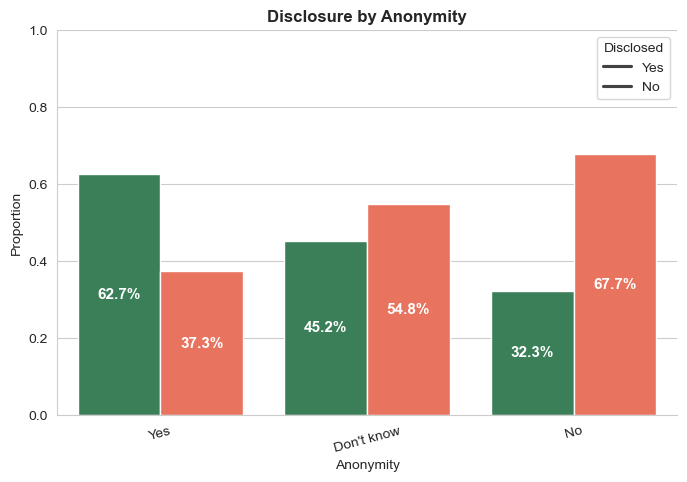

In [58]:
plot_factor(df, col="anonymity",
            order=["Yes", "Don't know", "No"],
            title="Disclosure by Anonymity")


# Disclosure by Leave Policy

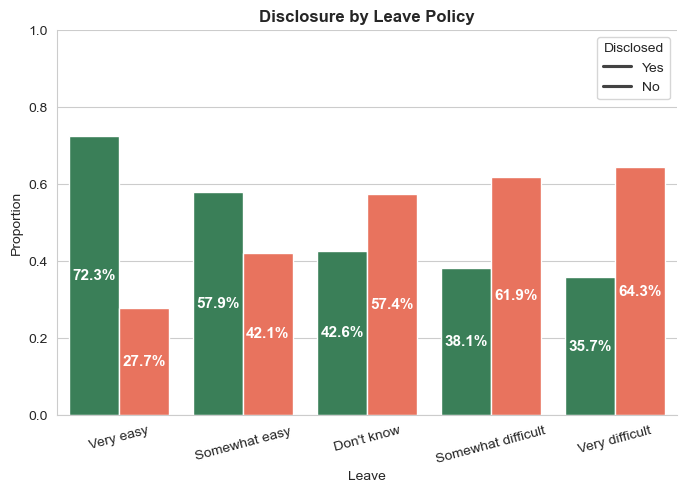

In [59]:
plot_factor(df, col="leave",
            order=["Very easy", "Somewhat easy", "Don't know", "Somewhat difficult", "Very difficult"],
            title="Disclosure by Leave Policy")


# Disclosure by Care Options Known

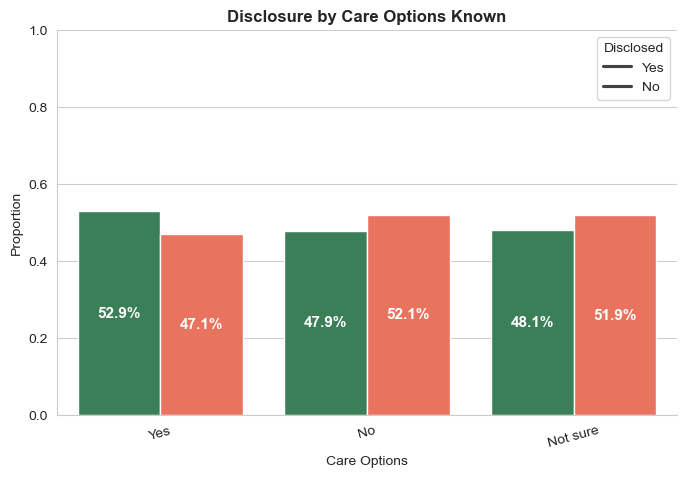

In [60]:
plot_factor(df, col="care_options",
            order=["Yes", "No", "Not sure"],
            title="Disclosure by Care Options Known")


# Disclosure by Seek-Help Channel Known

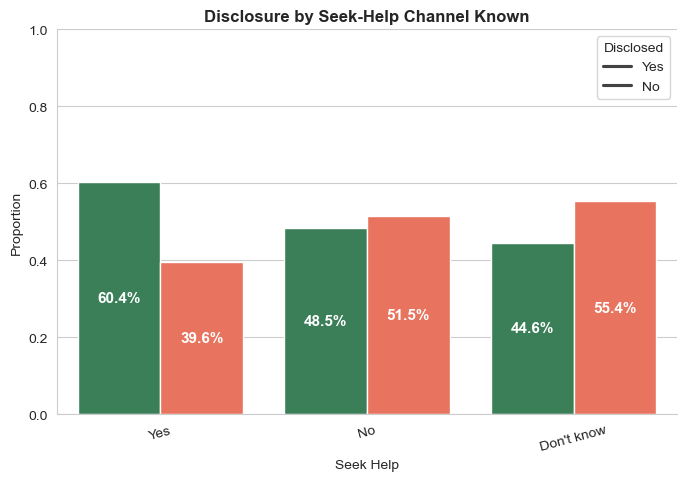

In [61]:
plot_factor(df, col="seek_help",
            order=["Yes", "No", "Don't know"],
            title="Disclosure by Seek-Help Channel Known")


# Disclosure by Benefits

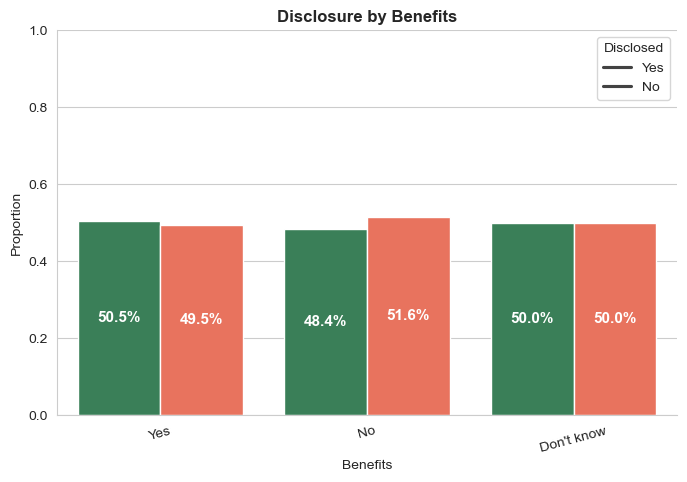

In [62]:
plot_factor(df, col="benefits",
            order=["Yes", "No", "Don't know"],
            title="Disclosure by Benefits")


### Most significant finding:

Culture and process—not benefits—drive disclosure. The ease of taking mental-health leave and the availability of anonymous channels have the biggest impact:

Leave policy (strongest): Very easy → 72.3% disclose vs Very difficult → 35.7% (≈ 36.6-point drop).

Anonymity (next strongest): Yes → 62.7% disclose vs No → 32.3% (≈ 30.4-point drop).

Supporting signals (moderate effects):

Know how to seek help: 60.4% vs 48.5% vs 44.6% (don’t know).

Know care options: 52.9% vs 47.9% (not sure 48.1%).

Minimal effect:

Benefits on paper: essentially ~50/50 across Yes/No/Don’t know → policy existence alone doesn’t move disclosure